In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# loading wide table
df_wide = pd.read_csv('../microservices/dash_app/wide.csv')
df_wide['datetime'] = pd.to_datetime(df_wide['hour'], format='%Y-%m-%d %H:%M:%S')
df_gamestop = df_wide.set_index('datetime')

train_org_df = df_gamestop[df_gamestop.index.year == 2020]
test_org_df = df_gamestop[df_gamestop.index.year == 2021]
test_org_df.head()

,hour,avg_all_post_pos,avg_all_post_neg,avg_all_post_neu,cnt_all_user,cnt_all_tag,cnt_all_post,cnt_all_comments,avg_gme_post_pos,avg_gme_post_neg,...,cnt_gme_tag,cnt_gme_post,cnt_gme_comments,id,volume,openprice,closeprice,highprice,lowprice,prediction
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00,2021-01-04 00:00:00,0.079373,0.079935,0.833351,92.0,45.0,137.0,134.0,0.000001,0.000001,...,1.0,1.0,1.0,1604.0,1695.0,19.1,19.4,19.4,19.1,-1.0
2021-01-04 01:00:00,2021-01-04 01:00:00,0.090065,0.086522,0.819869,147.0,62.0,280.0,277.0,0.120668,0.102334,...,1.0,3.0,3.0,1604.0,1695.0,19.1,19.4,19.4,19.1,-1.0
2021-01-04 02:00:00,2021-01-04 02:00:00,0.103936,0.079856,0.813165,169.0,84.0,324.0,319.0,0.065751,0.007501,...,1.0,4.0,3.0,1604.0,1695.0,19.1,19.4,19.4,19.1,-1.0
2021-01-04 03:00:00,2021-01-04 03:00:00,0.086609,0.081172,0.813798,120.0,56.0,217.0,211.0,0.000000,0.000000,...,0.0,0.0,0.0,1604.0,1695.0,19.1,19.4,19.4,19.1,-1.0
2021-01-04 04:00:00,2021-01-04 04:00:00,0.117629,0.058659,0.811240,197.0,88.0,401.0,385.0,0.200501,0.000001,...,1.0,4.0,3.0,1604.0,1695.0,19.1,19.4,19.4,19.1,-1.0


## Data Preprocessing

In [3]:
# finding missing values
df_wide.isnull().sum()

hour                0
avg_all_post_pos    0
avg_all_post_neg    0
avg_all_post_neu    0
cnt_all_user        0
cnt_all_tag         0
cnt_all_post        0
cnt_all_comments    0
avg_gme_post_pos    0
avg_gme_post_neg    0
avg_gme_post_neu    0
cnt_gme_user        0
cnt_gme_tag         0
cnt_gme_post        0
cnt_gme_comments    0
id                  0
volume              0
openprice           0
closeprice          0
highprice           0
lowprice            0
prediction          0
datetime            0
dtype: int64

In [4]:
# datatime for visualization
train_datetime_list = list(train_org_df.index)
test_datetime_list = list(test_org_df.index)
gamestop_datetime_list = list(df_gamestop.index)

In [8]:
# choose a feature set for training and testing 
feature_set_finn = ["openprice", "highprice", "lowprice", "volume", "closeprice"]

feature_set_wide = [
    "avg_all_post_pos",
    "avg_all_post_neg",
    "avg_all_post_neu",
    "cnt_all_user",
    "cnt_all_tag",
    "cnt_all_post",
    "cnt_all_comments",
    "avg_gme_post_pos",
    "avg_gme_post_neg",
    "avg_gme_post_neu",
    "cnt_gme_user",
    "cnt_gme_tag",
    "cnt_gme_post",
    "cnt_gme_comments",
    "volume",
    "openprice",
    "highprice",
    "lowprice",
    "closeprice"
]
feature_set_eng = [
    "avg_all_post_pos",
    "avg_all_post_neg",
    "avg_all_post_neu",
    "cnt_all_user",
    "cnt_all_tag",
    "cnt_all_post",
    "cnt_all_comments",
    "avg_gme_post_pos",
    "avg_gme_post_neg",
    "avg_gme_post_neu",
    "cnt_gme_user",
    "cnt_gme_tag",
    "cnt_gme_post",
    "cnt_gme_comments",
    "closeprice"
]

feature_label_cols = feature_set_wide
feature_cols = feature_label_cols[:-1]
label_cols = feature_label_cols[-1]

In [9]:
train_df = train_org_df[feature_label_cols]
test_df = test_org_df[feature_label_cols]

concat_df = df_gamestop[feature_label_cols]

In [10]:
def scale(df, feature_set, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        scaled_arr = scaler.fit_transform(df[feature_set])
    else:
        scaled_arr = scaler.transform(df[feature_set])
    return scaled_arr, scaler

def split(train_arr, train_ratio):
    # split the data to train, validate
    n = len(train_arr)
    train_set = train_arr[:int(n*train_ratio)]
    val_set = train_arr[int(n*train_ratio):]
    return train_set, val_set

### Data Windowing for time series forecasting

> Refer to [Data Windowing](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) for more details


In [11]:
# Generate time windows for time series forecasting with LSTM network
def generate_window(dataset, label, train_window, pred_horizon):
    dataset_seq = []
    size = len(dataset)
    x_arr = []
    y_arr = []
    for i in range(size - train_window - pred_horizon):
        x = dataset[i:(i+train_window), :]
        y = label[i+train_window+pred_horizon-1:i+train_window+pred_horizon]
        x_arr.append(x)
        y_arr.append(y)

    x_tensor = torch.tensor(x_arr).float()
    y_tensor = torch.tensor(y_arr).float()
    num_features = x_tensor.shape[2]
    dataset_seq = (x_tensor, y_tensor)
    return dataset_seq, num_features

def create_batch_set(dataset_seq, batch_size = 100):
    x_tensor, y_tensor = dataset_seq
    tensor_dataset = TensorDataset(x_tensor,y_tensor)
    tensor_dataloader = DataLoader(tensor_dataset, batch_size, False)
    return tensor_dataloader

In [12]:
# let's create sequential training dataset with various traning windows and prediction horizons
# given that the times series data has 1-hour resolution
# 24hours * (days)
train_window_list = [3, 5, 10, 24, 24*2, 24*5, 24*7]
prediction_horizon_list = [1, 2, 3, 5, 24*1, 24*2, 24*3]

# choose these set for testing 
train_window = train_window_list[3]
prediction_horizon = prediction_horizon_list[0]
print('train window: ', train_window)
print('prediction horizon: ', prediction_horizon)

train window:  24
prediction horizon:  1


In [13]:
label_train = train_df[label_cols]
label_test = test_df[label_cols]
label_all = concat_df[label_cols]



train_set, train_scaler = scale(train_df, feature_cols)
target_set, _ = scale(test_df, feature_cols, train_scaler)
train_set , val_set = split(train_set, 0.8)
label_train , label_val = split(label_train, 0.8)

gamestop_set, _ = scale(concat_df, feature_cols)

train_seq, num_features = generate_window(train_set, label_train, train_window, prediction_horizon)
val_seq, _ = generate_window(val_set, label_val, train_window, prediction_horizon)

x_train, _ =train_seq
x_val, _ = val_seq
train_batch_size = int(len(x_train)*0.5)
val_batch_size = int(len(x_val)*1)

train_batches = create_batch_set(train_seq, batch_size=300)
val_batches = create_batch_set(val_seq, batch_size=100)

target_seq, _ = generate_window(target_set, label_test, train_window, prediction_horizon)
gamestop_seq, _ = generate_window(gamestop_set, label_all, train_window, prediction_horizon)

datetime_target = test_datetime_list[train_window+prediction_horizon:]
datetime_gamestop = gamestop_datetime_list[train_window+prediction_horizon:]

x_train.shape

torch.Size([3623, 24, 18])

## Creating LSTM Network

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size=100, num_layers = 2, output_size=1):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seq_len = seq_length
        
        self.hidden_state = None
        self.cell_state = None
        self.hidden = (self.hidden_state, self.cell_state)

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )

        self.linear = nn.Linear(self.hidden_size * self.seq_len, self.output_size)

    def init_hidden(self, batch_size, device):
        self.hidden_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.cell_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.hidden = (self.hidden_state, self.cell_state)

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(
                x,
                self.hidden
            )
        outputs = self.linear(lstm_out.reshape(x.size(0),-1))
        return outputs


## Traning LSTM model

In [15]:
def train_model(model, device, train_batches, val_batches=None, num_epochs=50):

    learning_rate = 1e-3
    train_losses = []
    val_losses = []
    best_loss = np.Inf
    val_loss = None
    

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        batch_losses = []
        for batch_ndx, train_batch in enumerate(train_batches):
            model.train()
            x_train, y_train = train_batch
            batch_size = x_train.size(0)
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            model.init_hidden(batch_size, device)
            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_loss = loss.item()
            batch_losses.append(batch_loss)
            
        if val_batches is not None:
            model.eval()
            with torch.no_grad():
                val_batch_losses = []
                for _, val_batch in enumerate(val_batches):
                    x_val, y_val = val_batch
                    batch_size = x_val.size(0)
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    model.init_hidden(batch_size, device)
                    pred = model(x_val)
                    loss = criterion(pred, y_val)
                    val_loss = loss.item()
                    val_batch_losses.append(val_loss)
                    if val_loss < best_loss:
                        best_loss = val_loss
        
        val_losses_mean = np.mean(val_batch_losses)
        batch_losses_mean = np.mean(batch_losses)
        print(f"Epoch {epoch}: train loss {batch_losses_mean}, val loss {val_losses_mean}")
        val_losses.append(val_losses_mean)
        train_losses.append(batch_losses_mean)
        
        
    return model.eval(), train_losses, val_losses

In [16]:
# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)
# torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = LSTM(input_size=num_features, seq_length=train_window)
model.to(device)

model, train_losses, val_losses = train_model(model, device, train_batches, val_batches, num_epochs=100)

cuda
Epoch 0: train loss 44.04519748687744, val loss 169.88248358832465
Epoch 1: train loss 17.032594272723564, val loss 62.20089191860623
Epoch 2: train loss 1.4789279584701245, val loss 7.020456032620536
Epoch 3: train loss 2.945977884989518, val loss 12.212389985720316
Epoch 4: train loss 1.6010798066854477, val loss 6.4485545920001135
Epoch 5: train loss 0.8938527978383578, val loss 4.798223280244404
Epoch 6: train loss 0.5678198956526243, val loss 4.659507527947426
Epoch 7: train loss 0.35835538962139535, val loss 4.043447928296195
Epoch 8: train loss 0.4602910532401158, val loss 3.662146619624562
Epoch 9: train loss 0.6274038985944711, val loss 5.072498907645543
Epoch 10: train loss 1.3418138130353048, val loss 4.285326315297021
Epoch 11: train loss 1.5368989551296601, val loss 4.763315512074365
Epoch 12: train loss 2.4116086661815643, val loss 3.578213501307699
Epoch 13: train loss 1.5075584395000567, val loss 4.739198661512798
Epoch 14: train loss 1.7723212070189989, val loss 2

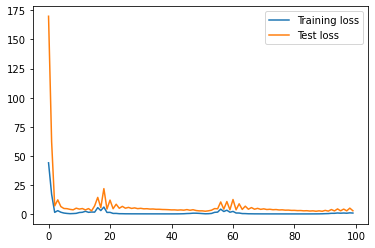

In [17]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Test loss")
plt.legend()

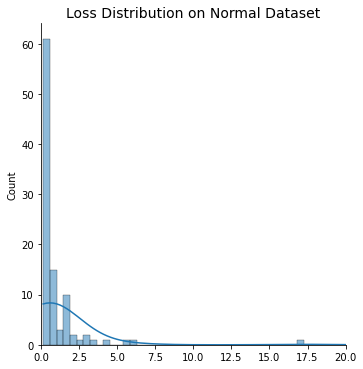

In [23]:
# fig_dims = (16, 9)
# fig, ax = plt.subplots(figsize=fig_dims)
sns_plot = sns.displot(train_losses, bins=100, kde=True)
plt.title("Loss Distribution on Normal Dataset", fontsize=14)
plt.xlim([0, 20])

if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig("figures/loss-dist-normal.pdf",dpi=300, bbox_inches='tight')

## Predictions

In [19]:
def predict(model, target_seq):
    observed, predicted, losses = [], [], []
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    criterion = nn.L1Loss(reduction='sum').to(device)
    model.to(device)
    print(device)

    X_test, y_test = target_seq
    set_size = X_test.size(0)

    # model.init_hidden(X_test.size(0), device)
    # y_pred = model(X_test)

    with torch.no_grad():
        model.eval()
        for i in range(set_size):
            x_i = X_test[i:i+1]
            y_i = y_test[i:i+1]
            x_i.to(device)
            y_i.to(device)
            model.init_hidden(x_i.size(0), device)
            y_pred = model(x_i)
            loss = criterion(y_pred, y_i)
            predicted.append(y_pred.item())
            losses.append(loss.item())
            
    observed = y_test.cpu().numpy().flatten()
    predictions = np.array(predicted).flatten()
    losses = np.array(losses).flatten()
    return predictions, observed, losses

In [20]:
predictions, observed, pred_losses = predict(model, target_seq)

cpu


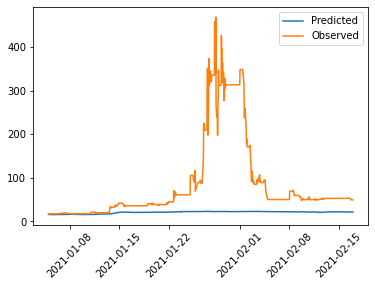

In [24]:
plt.plot(datetime_target,predictions, label="Predicted")
plt.plot(datetime_target, observed, label="Observed")
plt.xticks(rotation=45)
plt.legend()

Prediction loss mean = 68.0131798634487


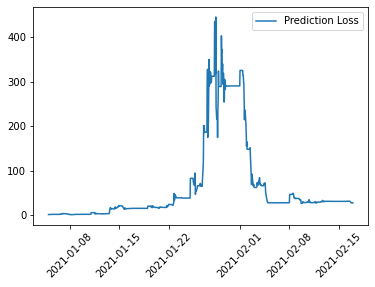

In [25]:
plt.plot(datetime_target ,pred_losses, label="Prediction Loss")
plt.xticks(rotation=45)
plt.legend()
print(f"Prediction loss mean = {np.mean(pred_losses)}")

<Figure size 1152x648 with 0 Axes>

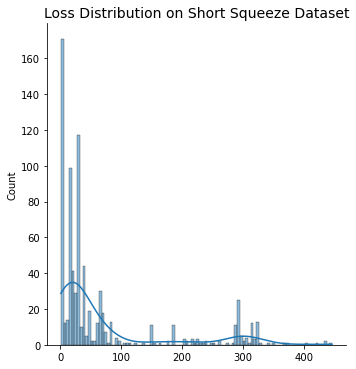

In [28]:
plt.figure(figsize=(16, 9))
sns.displot(pred_losses, bins=100, kde=True)
plt.title('Loss Distribution on Short Squeeze Dataset', fontsize=14)

if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig("figures/loss-dist-anomaly.pdf",dpi=300, bbox_inches='tight')

In [ ]:
test_org_df[label_cols].plot()
test_org_df['prediction'].plot()

In [ ]:
# add a prediciton column to the original dataframe
predictions, observed, losses = predict(model, gamestop_seq)

In [ ]:
df_gamestop['prediction'] = np.nan
X_test, y_test = gamestop_seq
set_size = X_test.size(0)
for i in range(set_size)
    df_gamestop.at[datetime_gamestop[i], 'prediction'] = predictions(i)

df_gamestop.to_csv('../foobar/data/processed/wide.csv')
print('The wide table is updated with the prediction results')

In [ ]:
plt.plot(datetime_gamestop,predictions, label="Predictions")
plt.plot(datetime_gamestop, truth, label="Truth")
plt.xticks(rotation=45)
plt.legend()

In [ ]:
print('Saving...')
state = {
    'model': model.state_dict(),
    'scaler': train_scaler,
    'feature_set': feature_set_wide,
    'train_loss': train_losses,
    'val_loss': val_losses,
    'pred_horizon': prediction_horizon,
    'train_window': train_window
}

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, f'./checkpoint/m2.pth')